## **Importing libraries and datasets**

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
df_response = pd.read_csv('Retail_Data_Response.csv')
df_transactions = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35.0
1,CS4768,2015-03-15,39.0
2,CS2122,2013-02-26,52.0
3,CS1217,2011-11-16,99.0
4,CS1850,2013-11-20,78.0


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35.0,764.0
1,CS4768,2015-03-15,39.0,2.0
2,CS2122,2013-02-26,52.0,749.0
3,CS1217,2011-11-16,99.0,1217.0
4,CS1850,2013-11-20,78.0,482.0


In [7]:
## create data set with RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum()}) # Monetary Value

df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value'}, inplace=True)

In [8]:
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value
0,CS1112,62.0,15,1012.0
1,CS1113,36.0,20,1490.0
2,CS1114,33.0,19,1432.0
3,CS1115,12.0,22,1659.0
4,CS1116,204.0,13,857.0


## **Calculating response rate**

In [9]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


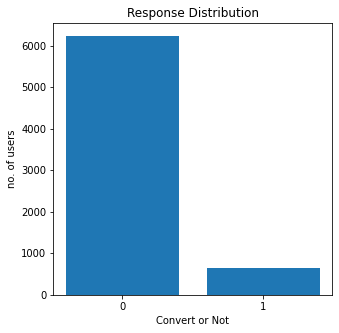

In [10]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [11]:
## merging two data sets

df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value
0,CS1112,0,62.0,15,1012.0
1,CS1113,0,36.0,20,1490.0
2,CS1114,1,33.0,19,1432.0
3,CS1115,1,12.0,22,1659.0
4,CS1116,1,204.0,13,857.0


## **Creating train and test dataset**

In [12]:
## spliting dataframe into X and y

X = df_modeling.drop(columns=['response','customer_id'])
y = df_modeling['response']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (3000, 3)
Number transactions y_train dataset:  (3000,)
Number transactions X_test dataset:  (2000, 3)
Number transactions y_test dataset:  (2000,)


Text(0.5, 1.0, 'Imbalanced Data')

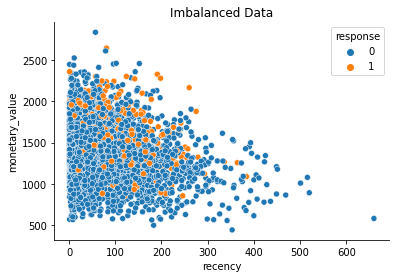

In [14]:
sns.scatterplot(data=df_modeling, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Undersampled Data')

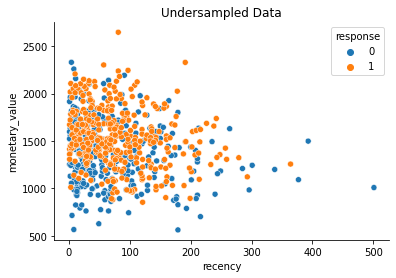

In [15]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled),pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

## **Fixing imbalanced with Oversampling**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Oversampled Data')

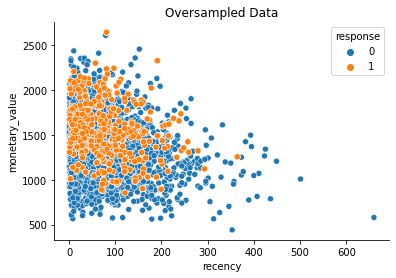

In [16]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled),pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

## **Fixing imbalanced with SMOTE**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'SMOTE Data')

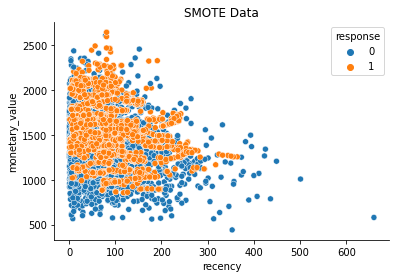

In [17]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE.columns= ['recency', 'frequency', 'monetary_value', 'response']

sns.scatterplot(data=df_SMOTE, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

## **Logistic Regression Model**

In [18]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.59      0.61      0.60       365
           1       0.60      0.59      0.59       365

    accuracy                           0.60       730
   macro avg       0.60      0.60      0.60       730
weighted avg       0.60      0.60      0.60       730

test set
              precision    recall  f1-score   support

           0       0.92      0.61      0.74      1768
           1       0.17      0.59      0.26       232

    accuracy                           0.61      2000
   macro avg       0.54      0.60      0.50      2000
weighted avg       0.83      0.61      0.68      2000



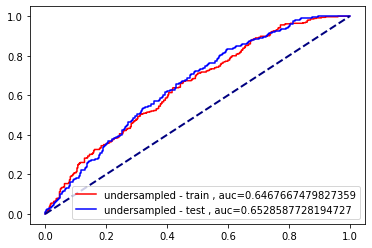

In [19]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [20]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[0.00448334 0.00592743 0.00127275]] [-2.30902876]


In [21]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.61      0.62      0.62      2635
           1       0.61      0.61      0.61      2635

    accuracy                           0.61      5270
   macro avg       0.61      0.61      0.61      5270
weighted avg       0.61      0.61      0.61      5270

test set
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      1768
           1       0.17      0.60      0.26       232

    accuracy                           0.61      2000
   macro avg       0.54      0.61      0.50      2000
weighted avg       0.83      0.61      0.68      2000



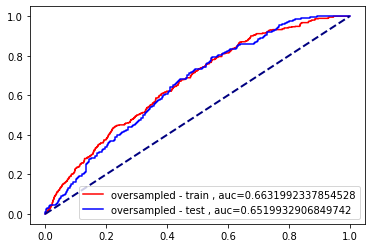

In [22]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [23]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[0.00411348 0.00964313 0.00162845]] [-2.30902876]


In [24]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      2635
           1       0.61      0.59      0.60      2635

    accuracy                           0.61      5270
   macro avg       0.61      0.61      0.61      5270
weighted avg       0.61      0.61      0.61      5270

test set
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      1768
           1       0.17      0.61      0.27       232

    accuracy                           0.61      2000
   macro avg       0.55      0.61      0.50      2000
weighted avg       0.84      0.61      0.68      2000



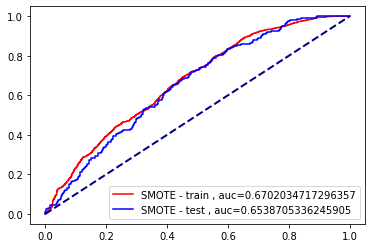

In [25]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [26]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[0.0052239  0.02384112 0.00160566]] [-2.30902876]


## **XGBoost**

In [27]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test)

XGBoost model - undersampled
[0]	validation_0-auc:0.624743
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.638293
[2]	validation_0-auc:0.63586
[3]	validation_0-auc:0.642227
[4]	validation_0-auc:0.642915
[5]	validation_0-auc:0.639764
[6]	validation_0-auc:0.641409
[7]	validation_0-auc:0.644476
[8]	validation_0-auc:0.646295
[9]	validation_0-auc:0.646627
[10]	validation_0-auc:0.6474
[11]	validation_0-auc:0.648331
[12]	validation_0-auc:0.648586
[13]	validation_0-auc:0.651547
[14]	validation_0-auc:0.65056
[15]	validation_0-auc:0.651584
[16]	validation_0-auc:0.651757
[17]	validation_0-auc:0.649293
[18]	validation_0-auc:0.649191
[19]	validation_0-auc:0.649466
[20]	validation_0-auc:0.649263
[21]	validation_0-auc:0.651757
Stopping. Best iteration:
[16]	validation_0-auc:0.651757

training set
              precision    recall  f1-score   support

           0       0.68      0.64      0.66       365
           1       0.66      0.70      0.68       365

    a

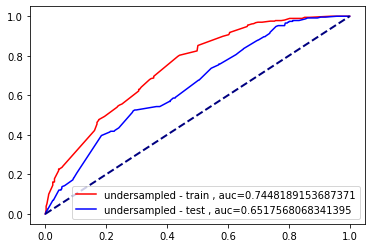

In [28]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

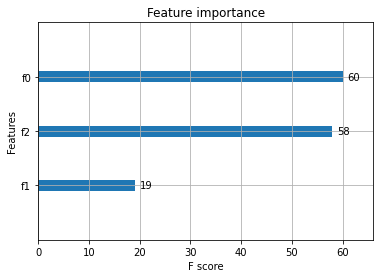

In [29]:
xgb.plot_importance(xgb_model_under)

In [30]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.653945
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.658924
[2]	validation_0-auc:0.657905
[3]	validation_0-auc:0.658678
[4]	validation_0-auc:0.658592
[5]	validation_0-auc:0.656194
[6]	validation_0-auc:0.663437
[7]	validation_0-auc:0.662883
[8]	validation_0-auc:0.663448
[9]	validation_0-auc:0.667182
[10]	validation_0-auc:0.671075
[11]	validation_0-auc:0.670775
[12]	validation_0-auc:0.673959
[13]	validation_0-auc:0.670791
[14]	validation_0-auc:0.671372
[15]	validation_0-auc:0.668865
[16]	validation_0-auc:0.66858
[17]	validation_0-auc:0.668976
Stopping. Best iteration:
[12]	validation_0-auc:0.673959

training set
              precision    recall  f1-score   support

           0       0.69      0.60      0.64      2635
           1       0.64      0.73      0.68      2635

    accuracy                           0.66      5270
   macro avg       0.66      0.66      0.66      5270
weighted avg       

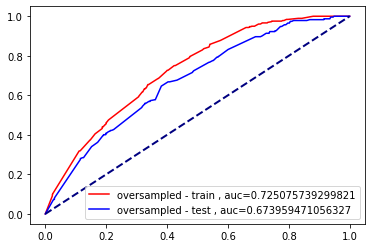

In [31]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

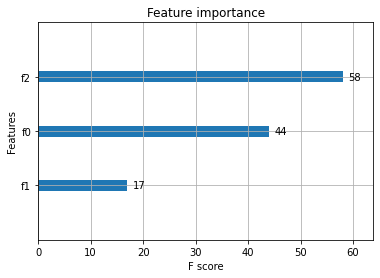

In [32]:
xgb.plot_importance(xgb_model_over)

In [33]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.645247
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.655355
[2]	validation_0-auc:0.661231
[3]	validation_0-auc:0.670248
[4]	validation_0-auc:0.673324
[5]	validation_0-auc:0.664066
[6]	validation_0-auc:0.665162
[7]	validation_0-auc:0.672126
[8]	validation_0-auc:0.671233
[9]	validation_0-auc:0.667446
Stopping. Best iteration:
[4]	validation_0-auc:0.673324

training set
              precision    recall  f1-score   support

           0       0.69      0.64      0.66      2635
           1       0.66      0.71      0.68      2635

    accuracy                           0.67      5270
   macro avg       0.67      0.67      0.67      5270
weighted avg       0.67      0.67      0.67      5270

test set
              precision    recall  f1-score   support

           0       0.93      0.63      0.75      1768
           1       0.18      0.63      0.28       232

    accuracy                           0.63  

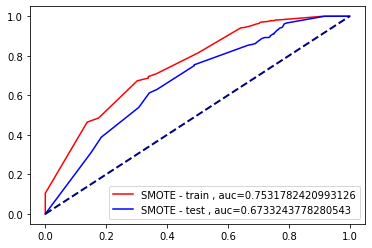

In [34]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

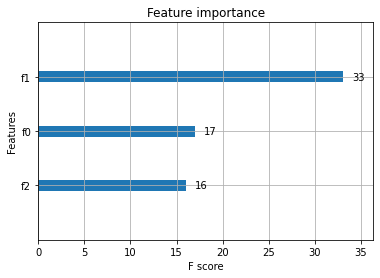

In [35]:
xgb.plot_importance(xgb_model_SMOTE)

In [36]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.579654
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.586549
[2]	validation_0-auc:0.638187
[3]	validation_0-auc:0.65788
[4]	validation_0-auc:0.649811
[5]	validation_0-auc:0.653479
[6]	validation_0-auc:0.649503
[7]	validation_0-auc:0.654443
[8]	validation_0-auc:0.648909
Stopping. Best iteration:
[3]	validation_0-auc:0.65788

training set
              precision    recall  f1-score   support

           0       0.68      0.70      0.69      2635
           1       0.69      0.67      0.68      2635

    accuracy                           0.68      5270
   macro avg       0.68      0.68      0.68      5270
weighted avg       0.68      0.68      0.68      5270

test set
              precision    recall  f1-score   support

           0       0.92      0.68      0.78      1768
           1       0.18      0.53      0.27       232

    accuracy                           0.67      2000
   m

### **Improve Model**

In [37]:
#Add  feature
campaign_date = dt.datetime(2015,3,17)
df_transactions['first_transaction']= campaign_date - df_transactions['trans_date']
df_transactions['first_transaction'].astype('timedelta64[D]')
df_transactions['first_transaction']=df_transactions['first_transaction'] / np.timedelta64(1, 'D')
df_transactions['age_of_T']= campaign_date - df_transactions['trans_date']
df_transactions['age_of_T'].astype('timedelta64[D]')
df_transactions['age_of_T']=df_transactions['age_of_T'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent,first_transaction,age_of_T
0,CS5295,2013-02-11,35.0,764.0,764.0,764.0
1,CS4768,2015-03-15,39.0,2.0,2.0,2.0
2,CS2122,2013-02-26,52.0,749.0,749.0,749.0
3,CS1217,2011-11-16,99.0,1217.0,1217.0,1217.0
4,CS1850,2013-11-20,78.0,482.0,482.0,482.0


In [38]:
# RFM variables

df_rfm = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value
                                                     'first_transaction': lambda x:x.max(),
                                                     'age_of_T': lambda x:x.max()-x.min()}) 
df_rfm.rename(columns={'recent': 'recency', 
                         'customer_id': 'frequency', 
                         'tran_amount': 'monetary_value',
                         'first_transaction': 'first_transaction',
                         'age_of_T': 'age_of_T'
                       }, inplace=True)

In [39]:
df_rfm['rfm'] = df_rfm['recency'] * df_rfm['frequency'] * df_rfm['monetary_value']

In [40]:
df_rfm = df_rfm.reset_index()
df_rfm.head()


,customer_id,recency,frequency,monetary_value,first_transaction,age_of_T,rfm
0,CS1112,62.0,15,1012.0,1371.0,1309.0,941160.0
1,CS1113,36.0,20,1490.0,1390.0,1354.0,1072800.0
2,CS1114,33.0,19,1432.0,1342.0,1309.0,897864.0
3,CS1115,12.0,22,1659.0,1315.0,1303.0,437976.0
4,CS1116,204.0,13,857.0,1359.0,1155.0,2272764.0


In [41]:
df_modeling = pd.merge(df_response,df_rfm)
df_modeling.head()

,customer_id,response,recency,frequency,monetary_value,first_transaction,age_of_T,rfm
0,CS1112,0,62.0,15,1012.0,1371.0,1309.0,941160.0
1,CS1113,0,36.0,20,1490.0,1390.0,1354.0,1072800.0
2,CS1114,1,33.0,19,1432.0,1342.0,1309.0,897864.0
3,CS1115,1,12.0,22,1659.0,1315.0,1303.0,437976.0
4,CS1116,1,204.0,13,857.0,1359.0,1155.0,2272764.0


In [42]:
## spliting dataframe X and y

X = df_modeling.drop(columns=['first_transaction','age_of_T','rfm','response','customer_id'])
# X = df_modeling[['age_of_T','rfm']]
y = df_modeling['response']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (3500, 3)
Number transactions y_train dataset:  (3500,)
Number transactions X_test dataset:  (1500, 3)
Number transactions y_test dataset:  (1500,)


In [44]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)
df_SMOTE_imp = pd.concat([pd.DataFrame(data=X_SMOTE),pd.DataFrame(data=y_SMOTE)], axis=1, sort=False)
df_SMOTE_imp.columns= ['recency', 'frequency', 'monetary_value', 'response']
# df_SMOTE_imp.columns= ['age_of_T','rfm', 'response']

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [45]:
df_SMOTE_imp['response'].unique()
df_SMOTE_imp.describe()

,recency,frequency,monetary_value,response
count,6146.000000,6146.000000,6146.000000,6146.000000
mean,74.526987,20.677697,1453.122302,0.500000
std,65.509241,4.281859,316.460878,0.500041
min,1.000000,6.000000,440.000000,0.000000
25%,25.256263,18.000000,1240.250000,0.000000
50%,59.745607,20.741102,1442.359473,0.500000
75%,105.000000,23.781464,1667.578690,1.000000
max,660.000000,38.000000,2647.000000,1.000000


Text(0.5, 1.0, 'SMOTE Data')

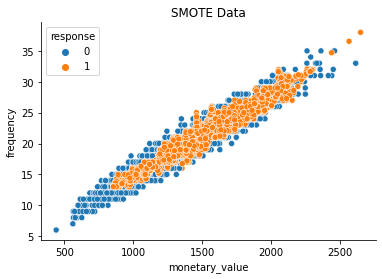

In [46]:
sns.scatterplot(data=df_SMOTE_imp, x='monetary_value', y='frequency', hue='response')
sns.despine()
plt.title("SMOTE Data")

Text(0.5, 1.0, 'SMOTE Data')

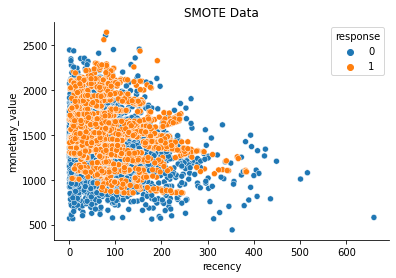

In [47]:
sns.scatterplot(data=df_SMOTE_imp, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("SMOTE Data")

Text(0.5, 1.0, 'SMOTE Data')

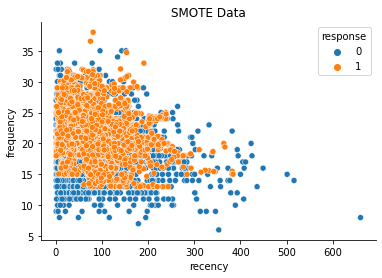

In [48]:
sns.scatterplot(data=df_SMOTE_imp, x='recency', y='frequency', hue='response')
sns.despine()
plt.title("SMOTE Data")

In [49]:
#Check Imbalance
df_SMOTE_imp.response.value_counts()

1    3073
0    3073
Name: response, dtype: int64

In [50]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [51]:
from sklearn.model_selection import KFold

In [52]:
#K-Fold Cross validation
kf = KFold(n_splits=12,shuffle=True,random_state=101)
for train_index, test_index in kf.split(X):
  X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
  y_train, y_test = y[train_index], y[test_index]
  print('Train Shape X: {} Y : {}'.format(X_train.shape,y_train.shape))
  print('Test Shape X: {} Y : {}'.format(X_test.shape,y_test.shape))
  
#Fix Imbalance with SMOTE
  sm = SMOTE(random_state=0)
  sm.fit(X_train, y_train)
  X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)

#XGb Model
  xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
    base_score=0.5,
    learning_rate =0.10,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=2,
    gamma=0.1,
    subsample=0.4,
    colsample_bytree=0.4,
    nthread=4)
  predicted_y = []
  expected_y = []

  xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
  predictions =  xgb_model_SMOTE.predict(X_SMOTE)
  predicted_y.extend(predictions)
  expected_y.extend(y_SMOTE)
  report_train = classification_report(expected_y, predicted_y)
  print('training set')
  print(report_train) 

  predicted_y = []
  expected_y = []
  predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
  predicted_y.extend(predictions)
  expected_y.extend(y_test)
  report_test = classification_report(expected_y, predicted_y)
  print('test set')
  print(report_test)

Train Shape X: (4583, 3) Y : (4583,)
Test Shape X: (417, 3) Y : (417,)
[0]	validation_0-auc:0.649844
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.644316
[2]	validation_0-auc:0.64323
[3]	validation_0-auc:0.694411
[4]	validation_0-auc:0.703738
[5]	validation_0-auc:0.697429
[6]	validation_0-auc:0.695699
[7]	validation_0-auc:0.693529
[8]	validation_0-auc:0.698481
[9]	validation_0-auc:0.695632
Stopping. Best iteration:
[4]	validation_0-auc:0.703738

training set
              precision    recall  f1-score   support

           0       0.70      0.65      0.67      4025
           1       0.67      0.72      0.69      4025

    accuracy                           0.68      8050
   macro avg       0.69      0.68      0.68      8050
weighted avg       0.69      0.68      0.68      8050

test set
              precision    recall  f1-score   support

           0       0.95      0.62      0.75       378
           1       0.15      0.67      0.25        3

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-auc:0.556203
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.545957
[2]	validation_0-auc:0.561268
[3]	validation_0-auc:0.564423
[4]	validation_0-auc:0.616803
[5]	validation_0-auc:0.617586
[6]	validation_0-auc:0.638953
[7]	validation_0-auc:0.661747
[8]	validation_0-auc:0.674411
[9]	validation_0-auc:0.680328
[10]	validation_0-auc:0.68263
[11]	validation_0-auc:0.681387
[12]	validation_0-auc:0.678785
[13]	validation_0-auc:0.675286
[14]	validation_0-auc:0.681088
[15]	validation_0-auc:0.68712
[16]	validation_0-auc:0.686867
[17]	validation_0-auc:0.68765
[18]	validation_0-auc:0.68963
[19]	validation_0-auc:0.689883
[20]	validation_0-auc:0.689561
[21]	validation_0-auc:0.689584
[22]	validation_0-auc:0.68765
[23]	validation_0-auc:0.68986
[24]	validation_0-auc:0.688893
Stopping. Best iteration:
[19]	validation_0-auc:0.689883

training set
              precision    recall  f1-score   support

           0       0.78      0.73      0.76      404

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


test set
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       370
           1       0.16      0.43      0.23        47

    accuracy                           0.69       417
   macro avg       0.53      0.57      0.52       417
weighted avg       0.82      0.69      0.74       417

Train Shape X: (4583, 3) Y : (4583,)
Test Shape X: (417, 3) Y : (417,)
[0]	validation_0-auc:0.533849
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.606851
[2]	validation_0-auc:0.669906
[3]	validation_0-auc:0.664881
[4]	validation_0-auc:0.676819
[5]	validation_0-auc:0.658912
[6]	validation_0-auc:0.644603
[7]	validation_0-auc:0.665162
[8]	validation_0-auc:0.672967
[9]	validation_0-auc:0.67437
Stopping. Best iteration:
[4]	validation_0-auc:0.676819

training set
              precision    recall  f1-score   support

           0       0.77      0.67      0.72      4040
           1       0.71      0.80      0.75      404

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-auc:0.561142
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.593842
[2]	validation_0-auc:0.601061
[3]	validation_0-auc:0.619988
[4]	validation_0-auc:0.613432
[5]	validation_0-auc:0.623355
[6]	validation_0-auc:0.631543
[7]	validation_0-auc:0.627079
[8]	validation_0-auc:0.625854
[9]	validation_0-auc:0.631364
[10]	validation_0-auc:0.639578
[11]	validation_0-auc:0.63996
[12]	validation_0-auc:0.641669
[13]	validation_0-auc:0.634961
[14]	validation_0-auc:0.634425
[15]	validation_0-auc:0.631976
[16]	validation_0-auc:0.63417
[17]	validation_0-auc:0.634119
Stopping. Best iteration:
[12]	validation_0-auc:0.641669

training set
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      4040
           1       0.75      0.75      0.75      4040

    accuracy                           0.75      8080
   macro avg       0.75      0.75      0.75      8080
weighted avg       0.75      0.75      0.75     

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-auc:0.554088
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.632155
[2]	validation_0-auc:0.613334
[3]	validation_0-auc:0.611435
[4]	validation_0-auc:0.607787
[5]	validation_0-auc:0.606017
[6]	validation_0-auc:0.615773
Stopping. Best iteration:
[1]	validation_0-auc:0.632155

training set
              precision    recall  f1-score   support

           0       0.71      0.57      0.63      4052
           1       0.64      0.76      0.70      4052

    accuracy                           0.67      8104
   macro avg       0.67      0.67      0.66      8104
weighted avg       0.67      0.67      0.66      8104

test set
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       351
           1       0.21      0.65      0.32        66

    accuracy                           0.56       417
   macro avg       0.55      0.60      0.50       417
weighted avg       0.78      0.56      0.62      

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


[0]	validation_0-auc:0.609045
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.755098
[2]	validation_0-auc:0.742207
[3]	validation_0-auc:0.766114
[4]	validation_0-auc:0.755019
[5]	validation_0-auc:0.775148
[6]	validation_0-auc:0.76791
[7]	validation_0-auc:0.755547
[8]	validation_0-auc:0.76017
[9]	validation_0-auc:0.759061
[10]	validation_0-auc:0.760936
Stopping. Best iteration:
[5]	validation_0-auc:0.775148

training set
              precision    recall  f1-score   support

           0       0.75      0.68      0.72      4039
           1       0.71      0.78      0.74      4039

    accuracy                           0.73      8078
   macro avg       0.73      0.73      0.73      8078
weighted avg       0.73      0.73      0.73      8078

test set
              precision    recall  f1-score   support

           0       0.94      0.69      0.79       364
           1       0.24      0.67      0.35        52

    accuracy                          

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Train Shape X: (4584, 3) Y : (4584,)
Test Shape X: (416, 3) Y : (416,)
[0]	validation_0-auc:0.599975
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.647983
[2]	validation_0-auc:0.630494
[3]	validation_0-auc:0.661949
[4]	validation_0-auc:0.67046
[5]	validation_0-auc:0.671426
[6]	validation_0-auc:0.678752
[7]	validation_0-auc:0.672611
[8]	validation_0-auc:0.66968
[9]	validation_0-auc:0.671364
[10]	validation_0-auc:0.674886
[11]	validation_0-auc:0.679126
[12]	validation_0-auc:0.673826
[13]	validation_0-auc:0.671083
[14]	validation_0-auc:0.672517
[15]	validation_0-auc:0.673452
[16]	validation_0-auc:0.672891
Stopping. Best iteration:
[11]	validation_0-auc:0.679126



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


training set
              precision    recall  f1-score   support

           0       0.77      0.65      0.70      4030
           1       0.69      0.80      0.74      4030

    accuracy                           0.72      8060
   macro avg       0.73      0.72      0.72      8060
weighted avg       0.73      0.72      0.72      8060

test set
              precision    recall  f1-score   support

           0       0.93      0.63      0.75       373
           1       0.15      0.58      0.24        43

    accuracy                           0.63       416
   macro avg       0.54      0.61      0.50       416
weighted avg       0.85      0.63      0.70       416

Train Shape X: (4584, 3) Y : (4584,)
Test Shape X: (416, 3) Y : (416,)
[0]	validation_0-auc:0.701183
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.718255
[2]	validation_0-auc:0.734034
[3]	validation_0-auc:0.678705
[4]	validation_0-auc:0.660001
[5]	validation_0-auc:0.683398
[6]	valida

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


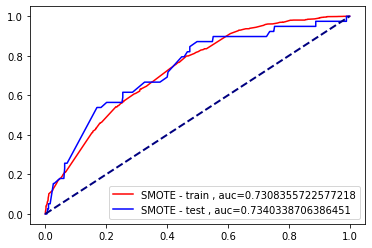

In [53]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()